In [39]:
import pandas as pd
import numpy as np
import datetime as dt

from tqdm import tqdm_notebook as tqdm
import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

In [2]:
# selecting all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn= conn, tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("start_date is not Null")
ss.load_studies()

251202 studies loaded!


In [3]:
ss.add_dimensions(['baseline_measurements', 'result_groups', 'outcome_analyses'])
ss.refresh_dim_data()
rg = ss.dimensions['result_groups']
bm = ss.dimensions['baseline_measurements']

Successfuly added these 3 dimensions: ['baseline_measurements', 'result_groups', 'outcome_analyses']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 503 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_analyses
 -- Loading raw data
 -- Sorting index


In [4]:
#Get studies with exactly two treatment groups besides "Total" and grab necessary columns
combined_measures = pd.merge(rg.data, bm.data, left_on = ['nct_id', 'id'], right_on = ['nct_id', 'result_group_id'])
combined_measures = combined_measures[combined_measures.title_x != 'Total']
num_groups = combined_measures.groupby('nct_id').ctgov_group_code_x.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
combined_measures = combined_measures.merge(num_groups, on=['nct_id'])
combined_measures = combined_measures[combined_measures.n_groups==2]
study_balance_dat = combined_measures[['ctgov_group_code_x', 'classification', 'category', 'title_y',
                                       'param_type', 'param_value_num',
                                       'dispersion_type', 'dispersion_value_num']]

In [5]:
study_balance_dat.title_y.value_counts().head(10)
#We'll go with age and sex for now

Age                           65726
Sex: Female, Male             64895
Race (NIH/OMB)                49782
Region of Enrollment          34515
Race/Ethnicity, Customized    23710
Ethnicity (NIH/OMB)           15139
Age, Customized                8579
Gender                         2318
Sex/Gender, Customized         1174
Weight                         1064
Name: title_y, dtype: int64

# Gender

In [8]:
df = study_balance_dat

In [9]:
gender_title_y = ['Sex: Female, Male', 
                  'Gender']

In [10]:
df[(df['title_y'].isin(gender_title_y)) & (df['category'] == '')]

,ctgov_group_code_x,classification,category,title_y,param_type,param_value_num,dispersion_type,dispersion_value_num
nct_id,,,,,,,,
NCT00002525,B2,Male,,Gender,Number,96.0,,NaN
NCT00002525,B2,Female,,Gender,Number,61.0,,NaN
NCT00002525,B1,Male,,Gender,Number,99.0,,NaN
NCT00002525,B1,Female,,Gender,Number,57.0,,NaN
NCT00068588,B3,Male,,Gender,Number,0.0,,NaN
...,...,...,...,...,...,...,...,...
NCT01928693,B2,Female,,Gender,Number,1.0,,NaN
NCT02648022,B2,Male,,Gender,Number,38.0,,NaN
NCT02648022,B2,Female,,Gender,Number,0.0,,NaN


In [11]:
def get_gender(row):
    if row['category'] == '':
        return row['classification'].lower()
    else: 
        return row['category'].lower()

In [12]:
df = study_balance_dat.copy()
df['filled_gender'] = df.apply(get_gender, axis=1)
df['is_gender'] = df['title_y'].apply(lambda x: True if x in gender_title_y else False)
dfj = df[df['is_gender']].join(ss.studies[['start_date']])
dfj['start_year'] = dfj['start_date'].apply(lambda x: x.year)

In [13]:
df_gender_year = dfj.groupby(['start_year', 
                              'filled_gender'])[['param_value_num']].sum().reset_index()
df_gender_yearp = df_gender_year.pivot(index='start_year', 
                                       columns='filled_gender', 
                                       values='param_value_num')

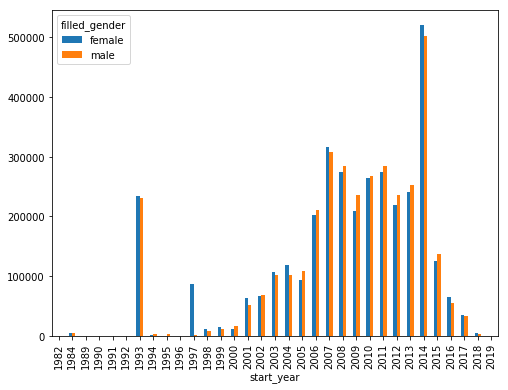

In [15]:
df_gender_yearp.plot.bar(figsize=(8, 6))
plt.show()

In [16]:
df_gres = dfj.groupby(['filled_gender'])[['param_value_num']].sum().reset_index()
df_gres['pct'] = df_gres['param_value_num'] / df_gres['param_value_num'].sum()

In [17]:
df_gres

,filled_gender,param_value_num,pct
0,female,3567142.0,0.503318
1,male,3520105.0,0.496682


## Distribution of Female / Total

In [19]:
dfj['param_type'].unique()

array(['Count of Participants', 'Number', 'Count of Units'], dtype=object)

In [24]:
df_per_study = dfj.groupby([dfj.index, 'filled_gender'])[['param_value_num']].sum()
df_psp = df_per_study.reset_index().pivot(index='nct_id', 
                                          columns='filled_gender',  
                                          values='param_value_num')
df_psp.head()

filled_gender,female,male
nct_id,,
NCT00000125,705.0,931.0
NCT00000135,22.0,187.0
NCT00000136,20.0,214.0
NCT00000143,12.0,49.0
NCT00000371,11.0,44.0


In [26]:
df_psp['fratio'] = df_psp['female'] / (df_psp['female'] + df_psp['male'])

In [34]:
fm, fs = df_psp['fratio'].mean(), df_psp['fratio'].std()

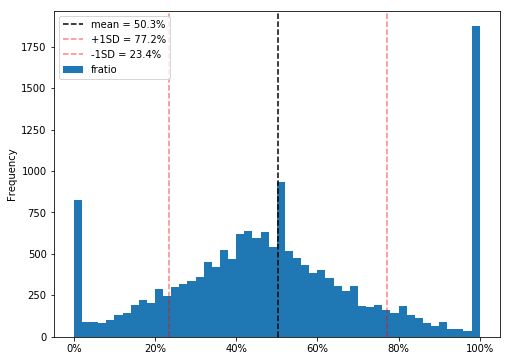

In [45]:
df_psp['fratio'].plot.hist(figsize=(8,6), bins=50)
plt.axvline(fm, linestyle='--', color='k', label='mean = %.1f%%' % (fm * 100))
plt.axvline(fm + fs, linestyle='--', color='r', alpha=0.5,
            label='+1SD = %.1f%%' % ((fm + fs) * 100))
plt.axvline(fm - fs, linestyle='--', color='r', alpha=0.5,
            label='-1SD = %.1f%%' % ((fm - fs) * 100))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend()
plt.show()

### How many are full women vs full men?

In [49]:
(df_psp['fratio'] == 1.).sum() / df_psp.shape[0]

0.10936847754785617

In [50]:
(df_psp['fratio'] == 0.).sum() / df_psp.shape[0]

0.046872204663366925